In [1]:
# Importamos las librerias a utilizar
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split,  GridSearchCV, cross_val_score
from sklearn.preprocessing import  StandardScaler, minmax_scale, MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from statsmodels.tsa.seasonal import seasonal_decompose
from xgboost import XGBClassifier

In [2]:
# Llamamos los 4 DFs para aplicar el EDA

contrato = pd.read_csv('final_provider/final_provider/contract.csv')
internet = pd.read_csv('final_provider/final_provider/internet.csv')
phone = pd.read_csv('final_provider/final_provider/phone.csv')
personal = pd.read_csv('final_provider/final_provider/personal.csv')

 ## ANÁLISIS EXPLORATORIO DE DATOS (EDA)

### Analizando el DF contrato

In [3]:
print(contrato.info())
print()
print(contrato.duplicated().sum())
print()
print(contrato.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None

0

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64


In [4]:
contrato.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95


In [5]:
# Renombramos el nombre de las columnas en el formato correcto.
rename_contrato = {'customerID': 'customer_id', 'BeginDate': 'begin_date', 'EndDate': 'end_date', 'Type': 'type', 'PaperlessBilling': 'paperless_billing', 'PaymentMethod':'payment_method', 'MonthlyCharges': 'monthly_charges', 'TotalCharges': 'total_charges'}
contrato = contrato.rename(columns=rename_contrato)
contrato.head(5)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


<Axes: xlabel='begin_date'>

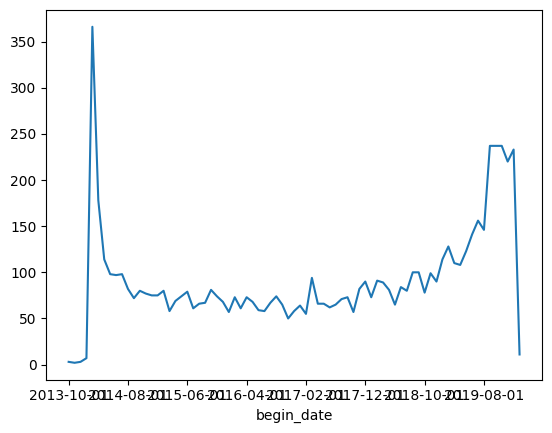

In [6]:
# Analizando los cantidad de contratos que se tiene desde el inicio de operacion.
contrato['begin_date'].value_counts().sort_index().plot(kind='line')

In [7]:
# Validamos los meses en el cual el cliente se retiro
contrato['end_date'].value_counts().sort_index()

end_date
2019-10-01 00:00:00     458
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
No                     5174
Name: count, dtype: int64

Podemos concluir que los ultimos 4 meses, los usuarios de TELCOM han desistido

In [8]:
# Convertimos la caracteristica fecha en formato datetime
contrato['begin_date'] = pd.to_datetime(contrato['begin_date'])

In [9]:
# Creamos una columna para calcular la fecha de antiguedad
fecha_corte = pd.to_datetime('2/1/2020', format='%d/%m/%Y')
contrato['fecha_activa'] = pd.to_datetime(contrato['end_date'], errors='coerce')# convierte a en formato fecha a las filas e ignora los valores vacios
contrato['fecha_activa'] = contrato['fecha_activa'].fillna(fecha_corte)
contrato['duracion_mes'] = ((contrato['fecha_activa'] - contrato['begin_date']).dt.days/30.4).round().astype(int)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_10228\366545018.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  contrato['fecha_activa'] = pd.to_datetime(contrato['end_date'], errors='coerce')# convierte a en formato fecha a las filas e ignora los valores vacios


In [10]:
# Eliminamos la columna "fecha_activa"
contrato = contrato.drop('fecha_activa', axis=1)
# Convierto la columna EndDate en una caracteristica de 2 categorias
contrato['end_date'].replace({'No': 'No', '2019-10-01 00:00:00':'Yes', '2019-11-01 00:00:00':'Yes', '2019-12-01 00:00:00':'Yes', '2020-01-01 00:00:00':'Yes'}, inplace=True)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_10228\1241048372.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  contrato['end_date'].replace({'No': 'No', '2019-10-01 00:00:00':'Yes', '2019-11-01 00:00:00':'Yes', '2019-12-01 00:00:00':'Yes', '2020-01-01 00:00:00':'Yes'}, inplace=True)


In [11]:
contrato['end_date'].value_counts(normalize=True)

end_date
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

<Axes: ylabel='Frequency'>

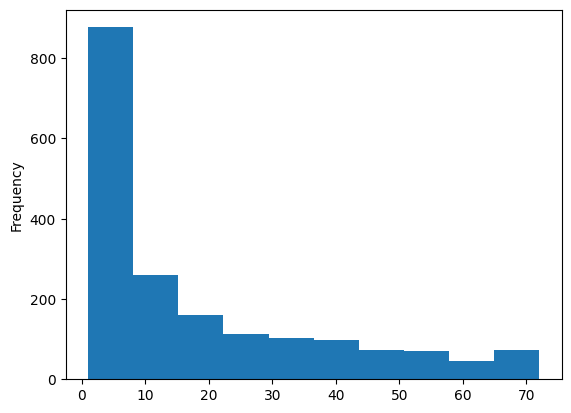

In [12]:
# Analizamos la cantidad de meses que la persona esta con TELCOM y luego desiste
clientes_que_desistieron = contrato[contrato['end_date'] == 'Yes']
clientes_que_desistieron['duracion_mes'].plot(kind='hist')

Se concluye que los clientes de TELCOM en los primeros 8 meses son mas suceptibles a cambiar de operador, que aquellos que pasan los 8 meses

## Analizando el DF Internet

In [13]:
print(internet.info())
print()
print(internet.duplicated().sum())
print()
print(internet.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None

0

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64


In [14]:
internet. head(9)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes


In [15]:
rename_internet = {'customerID': 'customer_id', 'InternetService': 'internet_service', 'OnlineSecurity': 'online_security', 'OnlineBackup': 'online_backup', 'DeviceProtection': 'device_protection', 'TechSupport': 'tech_support', 'StreamingTV': 'streaming_tv', 'StreamingMovies': 'streaming_movies'}
internet = internet.rename(columns = rename_internet)
internet.head(5)

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [16]:
# Analizando la cantidad de personas que cuentan con internet DSL vs Fibra optica
internet['internet_service'].value_counts(normalize=True)

internet_service
Fiber optic    0.561175
DSL            0.438825
Name: proportion, dtype: float64

El 56% de los clientes de TELCOM internet utilizan Fibra optica indicando su preferencia por la velocidad tanto de carga y descarga, a comparación del 44% que utiizan DSL, internet basico que se utiliza para envios de correos.

## Analizando el DF Phone

In [17]:
print(phone.info())
print()
print(phone.duplicated().sum())
print()
print(phone.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None

0

customerID       0
MultipleLines    0
dtype: int64


In [18]:
phone.head(5)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [19]:
rename_phone = {'customerID': 'customer_id', 'MultipleLines': 'multiple_lines'}
phone = phone.rename(columns=rename_phone)
phone.head(5)

,customer_id,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [20]:
phone['multiple_lines'].value_counts(normalize=True)

multiple_lines
No     0.532935
Yes    0.467065
Name: proportion, dtype: float64

## Analizando el DF personal

In [21]:
print(personal.info())
print()
print(personal.duplicated().sum())
print()
print(personal.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None

0

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64


In [22]:
personal.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [23]:
rename_personal = {'customerID': 'customer_id', 'SeniorCitizen': 'Senior_citizen', 'Partner':'partner', 'Dependents': 'dependents'}
personal = personal.rename(columns= rename_personal)
personal


,customer_id,gender,Senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


## Uniendo los 4 DFs aplicando merge

In [24]:
# Se une contrato con internet
comp = pd.merge(contrato, internet, on='customer_id', how='outer')
print(comp.sample(5))

     customer_id begin_date end_date            type paperless_billing  \
6814  9675-ICXCT 2014-02-01       No        Two year               Yes   
4434  6252-DFGTK 2017-01-01       No        One year                No   
1601  2330-PQGDQ 2015-11-01       No        One year                No   
5227  7356-IWLFW 2016-04-01       No  Month-to-month               Yes   
6486  9189-JWSHV 2017-12-01      Yes  Month-to-month               Yes   

                 payment_method  monthly_charges total_charges  duracion_mes  \
6814           Electronic check            80.80       5728.55            71   
4434    Credit card (automatic)            68.10       2479.25            36   
1601  Bank transfer (automatic)            84.20       4299.75            50   
5227  Bank transfer (automatic)            80.00        3769.7            45   
6486           Electronic check            93.55       2264.05            24   

     internet_service online_security online_backup device_protection  \
6

In [25]:
# Uniendo con el DF phone
compl = pd.merge(comp, phone, on= 'customer_id', how='outer')
print(compl.sample(5))


     customer_id begin_date end_date            type paperless_billing  \
5715  8050-DVOJX 2016-01-01       No        Two year                No   
5345  7551-DACSP 2019-05-01      Yes  Month-to-month               Yes   
6081  8621-MNIHH 2017-02-01      Yes  Month-to-month               Yes   
6675  9492-TOKRI 2018-04-01      Yes  Month-to-month               Yes   
1938  2812-REYAT 2016-01-01       No        One year               Yes   

                 payment_method  monthly_charges total_charges  duracion_mes  \
5715    Credit card (automatic)            81.35        4060.9            48   
5345               Mailed check            55.30        324.25             6   
6081           Electronic check            94.25       3217.55            34   
6675    Credit card (automatic)            90.00       1527.35            18   
1938  Bank transfer (automatic)            20.05         923.1            48   

     internet_service online_security online_backup device_protection  \
5

In [26]:
prueba_1= compl[(compl['internet_service'] != 'Fiber optic' ) & (compl['internet_service'] != 'DSL')]
prueba_1['monthly_charges'].describe()

count    1526.000000
mean       21.079194
std         2.164221
min        18.250000
25%        19.700000
50%        20.150000
75%        20.900000
max        26.900000
Name: monthly_charges, dtype: float64

Podemos evidenciar que aquellas personas que no cuentan con el servicio de internet, si cuentan con el servicio de telefonia fija, debido a que el recargo mensual que tienen aquellos van desde USD 18.25 hasta USD 26.90, es por ello, que se tomó la decesión de llenar los vacios de 'internet_service' con la palabra vacio No. 

In [27]:
# Imputando los valores vacios de la categoria Internet con la palbra No
reemplazo =~compl['internet_service'].isin(['Fiber optic', 'DSL'])
compl.loc[reemplazo] = compl.loc[reemplazo].fillna('No')

In [28]:
# Imputando los valores vacios de la categoria Multiplelines con la palabra No
reemplazo_2 = ~compl['multiple_lines'].isin(['Yes', 'No'])
compl.loc[reemplazo_2] = compl.loc[reemplazo_2].fillna('No')

In [29]:
#Hacemos Merge con el ultimo DF que falta.
completo = pd.merge(compl, personal,on='customer_id', how= 'outer')
completo.sample(5)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,duracion_mes,internet_service,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,gender,Senior_citizen,partner,dependents
19,0023-HGHWL,2019-10-01,Yes,Month-to-month,Yes,Electronic check,25.10,25.1,1,DSL,...,No,No,No,No,No,No,Male,1,No,No
4496,6341-JVQGF,2017-07-01,No,One year,Yes,Mailed check,81.15,2545.75,30,DSL,...,No,Yes,Yes,Yes,Yes,No,Female,0,Yes,Yes
6631,9424-CMPOG,2019-05-01,No,Two year,No,Mailed check,19.60,197.4,8,No,...,No,No,No,No,No,No,Male,0,Yes,Yes
2902,4134-BSXLX,2017-10-01,No,Month-to-month,No,Mailed check,60.90,1785.65,27,DSL,...,Yes,No,Yes,No,No,No,Male,0,Yes,No
957,1389-WNUIB,2018-06-01,No,One year,No,Bank transfer (automatic),76.00,1588.75,19,DSL,...,No,No,No,Yes,Yes,Yes,Female,0,Yes,Yes


In [30]:
# Validamos si contamos con valores vacios y duplicados, asimismo, el tipo de variable con el que contamos.
print(completo.info())
print()
print(completo.duplicated().sum())
print()
print(completo.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   object        
 8   duracion_mes       7043 non-null   int32         
 9   internet_service   7043 non-null   object        
 10  online_security    7043 non-null   object        
 11  online_backup      7043 non-null   object        
 12  device_protection  7043 non-null   object        
 13  tech_support       7043 non-null   object        
 14  streamin

In [31]:
# Se evidencia lineas arriba que se contaba con algunos valores vacios, procedemos a identificarlos y eliminarlos, ya que representan la minorio.
vacio = completo[completo['total_charges']== ' ']
vacio


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,duracion_mes,internet_service,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,gender,Senior_citizen,partner,dependents
945,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,-1,DSL,...,Yes,Yes,Yes,Yes,No,No,Female,0,Yes,Yes
1731,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,-1,No,...,No,No,No,No,No,No,Female,0,Yes,Yes
1906,2775-SEFEE,2020-02-01,No,Two year,Yes,Bank transfer (automatic),61.90,,-1,DSL,...,Yes,No,Yes,No,No,Yes,Male,0,No,Yes
2025,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,-1,No,...,No,No,No,No,No,No,Male,0,Yes,Yes
2176,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,-1,No,...,No,No,No,No,No,No,Male,0,No,Yes
2250,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,-1,No,...,No,No,No,No,No,Yes,Male,0,Yes,Yes
2855,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,,-1,DSL,...,Yes,Yes,Yes,Yes,No,Yes,Female,0,Yes,Yes
3052,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,-1,No,...,No,No,No,No,No,Yes,Male,0,Yes,Yes
3118,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,-1,DSL,...,No,Yes,Yes,Yes,No,No,Female,0,Yes,Yes
4054,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,-1,DSL,...,Yes,Yes,No,Yes,Yes,No,Female,0,Yes,Yes


In [32]:
completo['total_charges'] = pd.to_numeric(completo['total_charges'], errors='coerce')
completo = completo.dropna(subset=['total_charges'])

In [33]:
completo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7032 non-null   object        
 1   begin_date         7032 non-null   datetime64[ns]
 2   end_date           7032 non-null   object        
 3   type               7032 non-null   object        
 4   paperless_billing  7032 non-null   object        
 5   payment_method     7032 non-null   object        
 6   monthly_charges    7032 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   duracion_mes       7032 non-null   int32         
 9   internet_service   7032 non-null   object        
 10  online_security    7032 non-null   object        
 11  online_backup      7032 non-null   object        
 12  device_protection  7032 non-null   object        
 13  tech_support       7032 non-null   object        
 14  streaming_tv 

### Preparamos el DF para el modelo

In [34]:
# Se procede a eliminar la columna customer_id
completo = completo.drop('customer_id',axis=1)


📊 Variable: type
Frecuencia de categorías:
type
Month-to-month    0.551052
Two year          0.239619
One year          0.209329
Name: proportion, dtype: float64

Distribución respecto al churn:
end_date               No        Yes
type                                
Month-to-month  57.290323  42.709677
One year        88.722826  11.277174
Two year        97.151335   2.848665

📈 p-valor de chi-cuadrado: 0.0000
✅ Esta variable SÍ está relacionada con el churn.


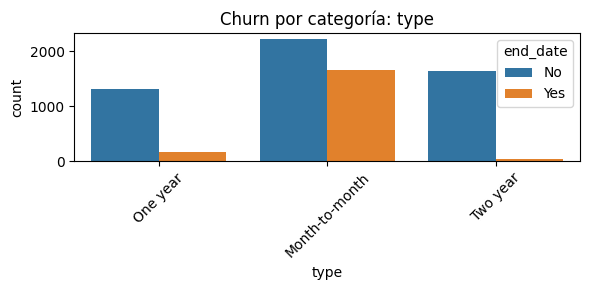


📊 Variable: paperless_billing
Frecuencia de categorías:
paperless_billing
Yes    0.592719
No     0.407281
Name: proportion, dtype: float64

Distribución respecto al churn:
end_date                  No        Yes
paperless_billing                      
No                 83.624302  16.375698
Yes                66.410749  33.589251

📈 p-valor de chi-cuadrado: 0.0000
✅ Esta variable SÍ está relacionada con el churn.


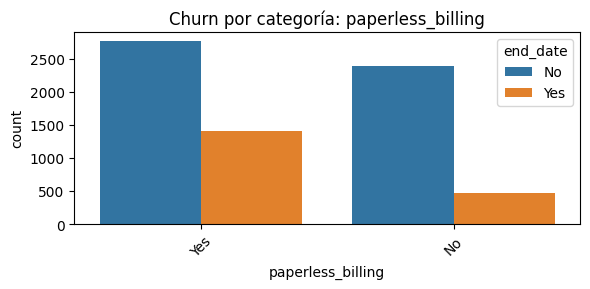


📊 Variable: payment_method
Frecuencia de categorías:
payment_method
Electronic check             0.336320
Mailed check                 0.228100
Bank transfer (automatic)    0.219283
Credit card (automatic)      0.216297
Name: proportion, dtype: float64

Distribución respecto al churn:
end_date                          No        Yes
payment_method                                 
Bank transfer (automatic)  83.268482  16.731518
Credit card (automatic)    84.746877  15.253123
Electronic check           54.714588  45.285412
Mailed check               80.798005  19.201995

📈 p-valor de chi-cuadrado: 0.0000
✅ Esta variable SÍ está relacionada con el churn.


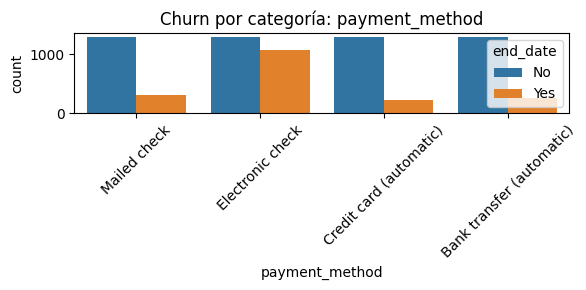


📊 Variable: internet_service
Frecuencia de categorías:
internet_service
Fiber optic    0.440273
DSL            0.343572
No             0.216155
Name: proportion, dtype: float64

Distribución respecto al churn:
end_date                 No        Yes
internet_service                      
DSL               81.001656  18.998344
Fiber optic       58.107235  41.892765
No                92.565789   7.434211

📈 p-valor de chi-cuadrado: 0.0000
✅ Esta variable SÍ está relacionada con el churn.


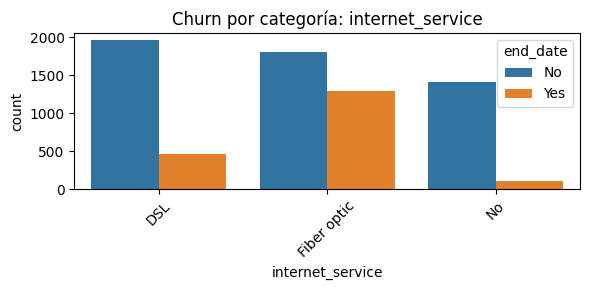


📊 Variable: online_security
Frecuencia de categorías:
online_security
No     0.713453
Yes    0.286547
Name: proportion, dtype: float64

Distribución respecto al churn:
end_date                No        Yes
online_security                      
No               68.626669  31.373331
Yes              85.359801  14.640199

📈 p-valor de chi-cuadrado: 0.0000
✅ Esta variable SÍ está relacionada con el churn.


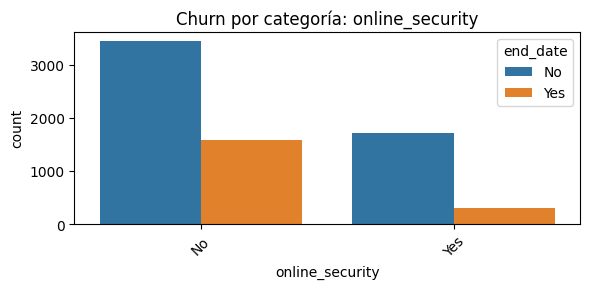


📊 Variable: online_backup
Frecuencia de categorías:
online_backup
No     0.655148
Yes    0.344852
Name: proportion, dtype: float64

Distribución respecto al churn:
end_date             No       Yes
online_backup                    
No             70.78359  29.21641
Yes            78.43299  21.56701

📈 p-valor de chi-cuadrado: 0.0000
✅ Esta variable SÍ está relacionada con el churn.


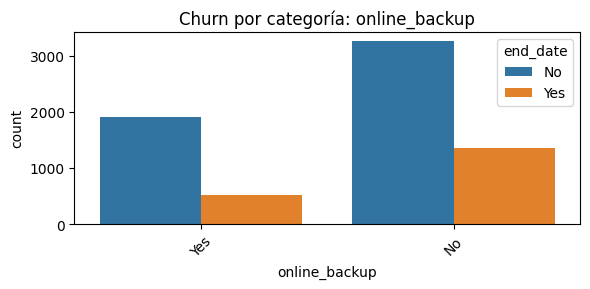


📊 Variable: device_protection
Frecuencia de categorías:
device_protection
No     0.656143
Yes    0.343857
Name: proportion, dtype: float64

Distribución respecto al churn:
end_date                  No        Yes
device_protection                      
No                 71.304725  28.695275
Yes                77.460711  22.539289

📈 p-valor de chi-cuadrado: 0.0000
✅ Esta variable SÍ está relacionada con el churn.


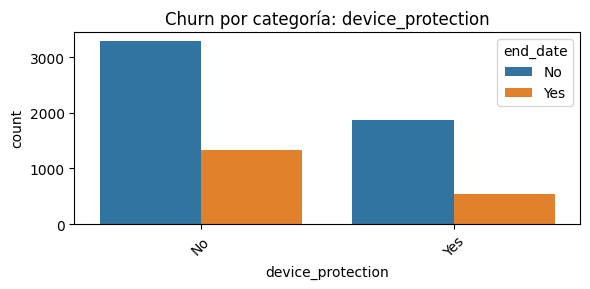


📊 Variable: tech_support
Frecuencia de categorías:
tech_support
No     0.709898
Yes    0.290102
Name: proportion, dtype: float64

Distribución respecto al churn:
end_date             No        Yes
tech_support                      
No            68.770032  31.229968
Yes           84.803922  15.196078

📈 p-valor de chi-cuadrado: 0.0000
✅ Esta variable SÍ está relacionada con el churn.


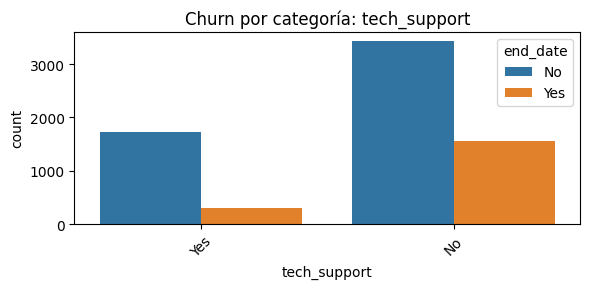


📊 Variable: streaming_tv
Frecuencia de categorías:
streaming_tv
No     0.615614
Yes    0.384386
Name: proportion, dtype: float64

Distribución respecto al churn:
end_date             No        Yes
streaming_tv                      
No            75.629476  24.370524
Yes           69.885313  30.114687

📈 p-valor de chi-cuadrado: 0.0000
✅ Esta variable SÍ está relacionada con el churn.


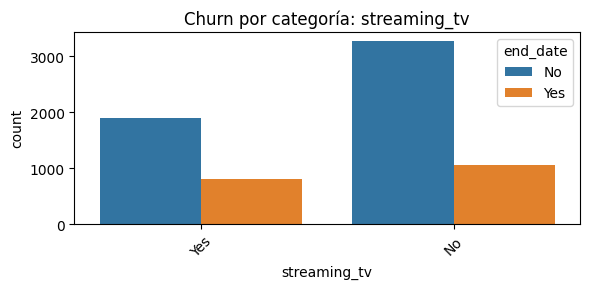


📊 Variable: streaming_movies
Frecuencia de categorías:
streaming_movies
No     0.611633
Yes    0.388367
Name: proportion, dtype: float64

Distribución respecto al churn:
end_date                 No        Yes
streaming_movies                      
No                75.563822  24.436178
Yes               70.047602  29.952398

📈 p-valor de chi-cuadrado: 0.0000
✅ Esta variable SÍ está relacionada con el churn.


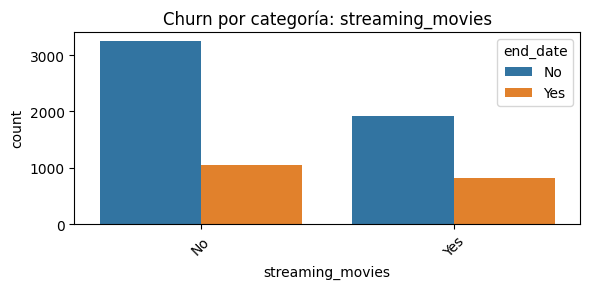


📊 Variable: multiple_lines
Frecuencia de categorías:
multiple_lines
No     0.578072
Yes    0.421928
Name: proportion, dtype: float64

Distribución respecto al churn:
end_date               No        Yes
multiple_lines                      
No              74.932349  25.067651
Yes             71.351534  28.648466

📈 p-valor de chi-cuadrado: 0.0009
✅ Esta variable SÍ está relacionada con el churn.


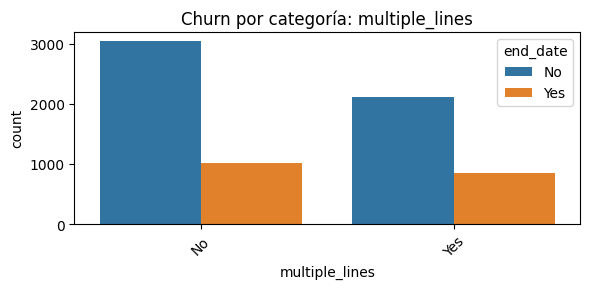


📊 Variable: gender
Frecuencia de categorías:
gender
Male      0.504693
Female    0.495307
Name: proportion, dtype: float64

Distribución respecto al churn:
end_date         No        Yes
gender                        
Female    73.040482  26.959518
Male      73.795435  26.204565

📈 p-valor de chi-cuadrado: 0.4905
⚠️ Esta variable NO muestra relación estadísticamente significativa.


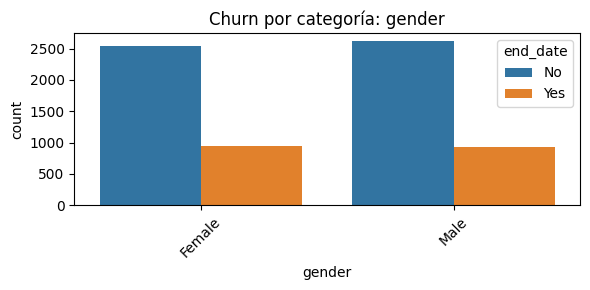


📊 Variable: partner
Frecuencia de categorías:
partner
No     0.517491
Yes    0.482509
Name: proportion, dtype: float64

Distribución respecto al churn:
end_date         No        Yes
partner                       
No        67.023908  32.976092
Yes       80.282935  19.717065

📈 p-valor de chi-cuadrado: 0.0000
✅ Esta variable SÍ está relacionada con el churn.


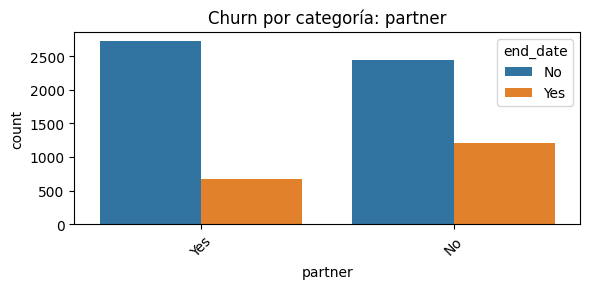


📊 Variable: dependents
Frecuencia de categorías:
dependents
No     0.701507
Yes    0.298493
Name: proportion, dtype: float64

Distribución respecto al churn:
end_date           No        Yes
dependents                      
No          68.720860  31.279140
Yes         84.468795  15.531205

📈 p-valor de chi-cuadrado: 0.0000
✅ Esta variable SÍ está relacionada con el churn.


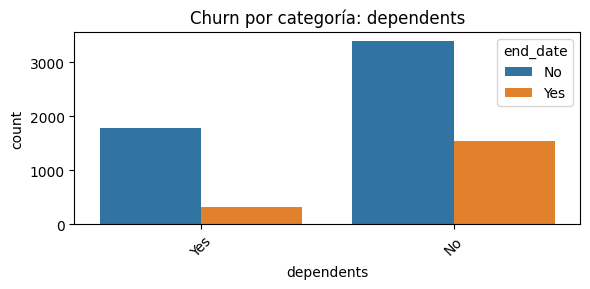

In [35]:
# Procedemos a Analizar cada categoria con respecto a nuestra varaiable objetivo
columnas = completo.select_dtypes(include=['object', 'category']).columns.drop('end_date')

for col in columnas:
    print(f'\n📊 Variable: {col}')
    print('Frecuencia de categorías:')
    print(completo[col].value_counts(dropna=False, normalize=True))
    
    print('\nDistribución respecto al churn:')
    print(pd.crosstab(completo[col], completo['end_date'], normalize='index') * 100)
    
    tabla = pd.crosstab(completo[col], completo['end_date'])
    chi2, p, _, _ = chi2_contingency(tabla)
    print(f'\n📈 p-valor de chi-cuadrado: {p:.4f}')
    
    if p < 0.05:
        print('✅ Esta variable SÍ está relacionada con el churn.')
    else:
        print('⚠️ Esta variable NO muestra relación estadísticamente significativa.')

    plt.figure(figsize=(6,3))
    sns.countplot(x=col, hue='end_date', data=completo)
    plt.title(f'Churn por categoría: {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

De acuerdo al Analizis realizado a las categorias con respecto al target, indican que la categoria 'gender' no se encuentra relacionado con el Churn.

## Empezamos en codificar nuestro DF.

### Aplciamos One Hot Encoding

In [36]:
completo_escalado_categorica = pd.get_dummies(completo, drop_first=True)
completo_escalado_categorica.head(5)

,begin_date,monthly_charges,total_charges,duracion_mes,Senior_citizen,end_date_Yes,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),...,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,multiple_lines_Yes,gender_Male,partner_Yes,dependents_Yes
0,2019-05-01,65.6,593.30,8,0,False,True,False,True,False,...,False,True,False,True,True,False,False,False,True,True
1,2019-05-01,59.9,542.40,8,0,False,False,False,False,False,...,False,False,False,False,False,True,True,True,False,False
2,2019-09-01,73.9,280.85,4,0,True,False,False,True,False,...,False,False,True,False,False,False,False,True,False,False
3,2018-12-01,98.0,1237.85,13,1,True,False,False,True,False,...,False,True,True,False,True,True,False,True,True,False
4,2019-09-01,83.9,267.40,3,1,True,False,False,True,False,...,False,False,False,True,True,False,False,False,True,False


In [37]:
# Escalaremos la variable numetica
escalado_numerico = completo_escalado_categorica.copy()

In [38]:
# Particionamos la base de datos en train y test
features = escalado_numerico.drop(columns=['end_date_Yes', 'begin_date', 'gender_Male', 'multiple_lines_Yes'])
target = escalado_numerico['end_date_Yes']


features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.30, random_state=123, stratify=None)

In [39]:
# Convertimos nuestro DF en 0 y 1
escalado_numerico.iloc[:,1:]= escalado_numerico.iloc[:,1:].astype(float)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_10228\3380648782.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0        8.0
1        8.0
2        4.0
3       13.0
4        3.0
        ... 
7038    12.0
7039    22.0
7040     1.0
7041    66.0
7042    62.0
Name: duracion_mes, Length: 7032, dtype: float64' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  escalado_numerico.iloc[:,1:]= escalado_numerico.iloc[:,1:].astype(float)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_10228\3380648782.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0       0.0
1       0.0
2       0.0
3       1.0
4       1.0
       ... 
7038    0.0
7039    0.0
7040    0.0
7041    0.0
7042    0.0
Name: Senior_citizen, Length: 7032, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.


In [40]:
# Escalamos las variables numericas
# Se aplica el MinMaxScaler ya que con ello obtuvimos un mejor resultado en comparacion al resto
from sklearn.preprocessing import MinMaxScaler
numeric = ['monthly_charges', 'total_charges', 'duracion_mes']

scaler = MinMaxScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [41]:
# Creamos una funcion para la evaluacion de modelos

def evaluar_modelo_binario(modelo, features_train, target_train, features_test, target_test, nombre_modelo='Modelo'):
    # Entrenamiento
    modelo.fit(features_train, target_train)
    
    # Predicciones
    y_pred = modelo.predict(features_test)
    y_proba = modelo.predict_proba(features_test)[:, 1]
    
    # Métricas
    auc = roc_auc_score(target_test, y_proba)
    acc = accuracy_score(target_test, y_pred)
    
    print(f'\n🔍 Evaluando: {nombre_modelo}')
    print(f'🎯 AUC-ROC: {auc:.4f}')
    print(f'📊 Exactitud: {acc:.4f}')
    print('\n📋 Reporte de clasificación:')
    print(classification_report(target_test, y_pred))
    
    # Matriz de confusión
    print('📊 Matriz de confusión:')
    display(pd.crosstab(index=target_test, columns=y_pred, rownames=['Real'], colnames=['Predicho']).style.background_gradient(cmap='Reds'))
    
    # Curva ROC
    fpr, tpr, _ = roc_curve(target_test, y_proba)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}', color='blue')
    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.xlabel('Falsos positivos')
    plt.ylabel('Verdaderos positivos')
    plt.title(f'Curva ROC - {nombre_modelo}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    

    return auc, acc


🔍 Evaluando: Logistic Regression
🎯 AUC-ROC: 0.8312
📊 Exactitud: 0.7967

📋 Reporte de clasificación:
              precision    recall  f1-score   support

       False       0.84      0.90      0.87      1553
        True       0.64      0.52      0.58       557

    accuracy                           0.80      2110
   macro avg       0.74      0.71      0.72      2110
weighted avg       0.79      0.80      0.79      2110

📊 Matriz de confusión:


Predicho,False,True
Real,,
False,1390,163
True,266,291


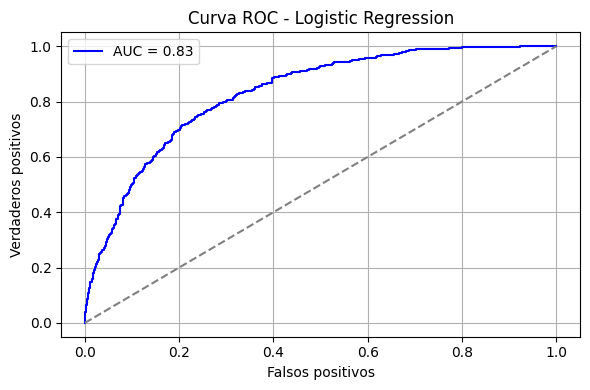

In [42]:
modelo_logreg = LogisticRegression(solver='liblinear', random_state=42)

regre_logis_auc, regre_logis_acc = evaluar_modelo_binario(modelo_logreg, features_train, target_train, features_test, target_test, nombre_modelo='Logistic Regression')


🔍 Evaluando: Randon Forest
🎯 AUC-ROC: 0.8617
📊 Exactitud: 0.7915

📋 Reporte de clasificación:
              precision    recall  f1-score   support

       False       0.89      0.81      0.85      1553
        True       0.58      0.73      0.65       557

    accuracy                           0.79      2110
   macro avg       0.74      0.77      0.75      2110
weighted avg       0.81      0.79      0.80      2110

📊 Matriz de confusión:


Predicho,False,True
Real,,
False,1264,289
True,151,406


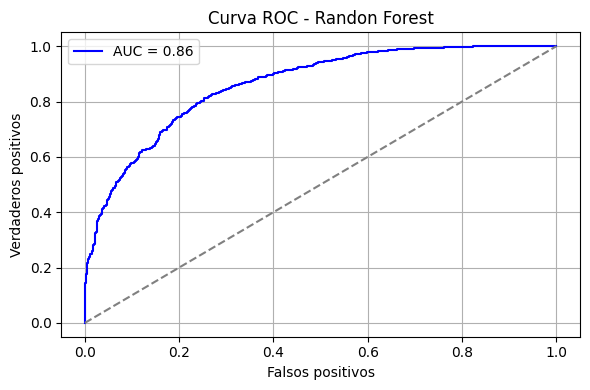

In [43]:
modelo_randonforest = RandomForestClassifier(random_state=42, n_estimators=200, max_depth=10, min_samples_split=5,
    min_samples_leaf=2,class_weight='balanced')
rando_forest_auc, rando_forest_acc = evaluar_modelo_binario(modelo_randonforest, features_train, target_train, features_test, target_test, nombre_modelo='Randon Forest')


🔍 Evaluando: Gradient Boosting
🎯 AUC-ROC: 0.8776
📊 Exactitud: 0.8355

📋 Reporte de clasificación:
              precision    recall  f1-score   support

       False       0.86      0.93      0.89      1553
        True       0.74      0.58      0.65       557

    accuracy                           0.84      2110
   macro avg       0.80      0.75      0.77      2110
weighted avg       0.83      0.84      0.83      2110

📊 Matriz de confusión:


Predicho,False,True
Real,,
False,1441,112
True,235,322


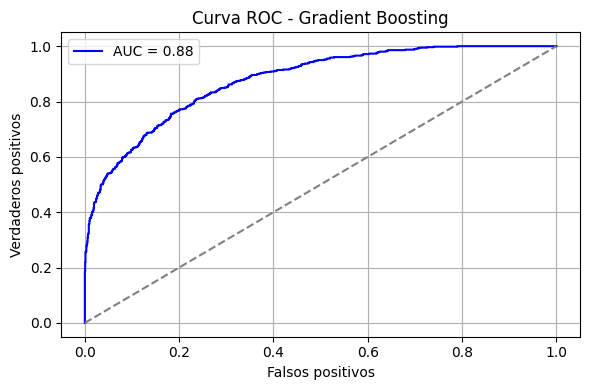

In [44]:
modelo_gradient = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate= 0.1,
    max_depth= 4,
    min_samples_split= 2,
    subsample=0.8,
    random_state=42
)
gradient_auc, gradient_acc = evaluar_modelo_binario(modelo_gradient, features_train, target_train, features_test, target_test, nombre_modelo='Gradient Boosting')

c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:30:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🔍 Evaluando: XBG Classifier
🎯 AUC-ROC: 0.8861
📊 Exactitud: 0.8403

📋 Reporte de clasificación:
              precision    recall  f1-score   support

       False       0.87      0.93      0.90      1553
        True       0.75      0.60      0.66       557

    accuracy                           0.84      2110
   macro avg       0.81      0.76      0.78      2110
weighted avg       0.83      0.84      0.83      2110

📊 Matriz de confusión:


Predicho,0,1
Real,,
False,1440,113
True,224,333


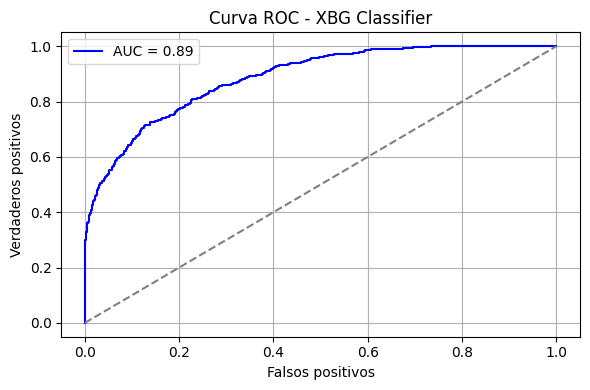

In [45]:
model_XBG = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,   # útil para clases desbalanceadas
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_auc, xgb_acc = evaluar_modelo_binario(model_XBG, features_train, target_train, features_test, target_test, nombre_modelo='XBG Classifier')

In [47]:
data_resumen = pd.DataFrame(dict(
AUC_ROC = [regre_logis_auc, rando_forest_auc, gradient_auc, xgb_auc], Exactitud = [regre_logis_acc, rando_forest_acc, gradient_acc, xgb_acc]),index=['Logistic Regression', 'Randon Forest', 'Gradient Boosting', 'XBG Classifier'])
data_resumen

,AUC_ROC,Exactitud
Logistic Regression,0.831205,0.796682
Randon Forest,0.861742,0.791469
Gradient Boosting,0.877567,0.835545
XBG Classifier,0.886107,0.840284


# Conclusion

Para el presente proyecto de analisis de Churn de la empresa TELCOM, se procedio a elaborar 4 modelos de ML teneiendo como resultado que el modelo XGB Classfier obtuvo mejores resultados en las siguientes metricas AUC ROC y Exactitud con 0.88 y 0.84 de exactitud, lo que representa que es un buen modelo discriminando las clases 

## Informe de solucion

EL trabajo realizado se apego al plan de trabajo inicial analizando cada DF y colocando en el formato snake como se planteo, luego de ello procedimos a preparar los datos e eliminar algunos de ellos que se considero irrelevante. Escalamos los datos para un mejor resulatdo, ademas, una vez propabado varios modelos, se llego a concluir que para este caso no era necesario balancear los datos, pero si aplicas otro tipo de codificaciòn como el MinMaxScaler, debido a que preserva la distribucion original y solo cambiando la escala.

El problema presentado fue mas de tipeo, ya que se estuvo manteniendo la misma variable en todos los  modelos y esto producia el mismo resultado en todos los modelos presentados.

Asismimo, comentar que el poder iniciar el proyecto fue complicado, ya que no tenia una ruta establecida, es por ello que, la elaboración del plan de trabajo me ayudo a construir un camino que seguir, ya en el trayecto, se presentaron mas actividades a realizar y estas se fueron complementando, asimismo, una vez realizado todas las 9 pruebas realizadas con tres modelos seleccionados, se llego a la conclusion que el modelo XBG Classifier obtuvo las mejores metricas con un AUC ROC de 0.88 y una exactitud de 84 %.